# Double-Bracket Iteration Strategy: magnetic field (onsite Z)
This notebook shows the diagonalization process of DBI using the magnetic field strategy, which varies the diagonal operator $D$ by gradient descent. To find the gradient with respect to $D$, parameterization of $D$ is required. For the purpose of this notebook, we represent it by onsite Pauli-Z operators, i.e.

$$ D = \sum \alpha_i Z_i $$

Note that it is also possible to have higher-order terms, such as $ D = \sum \alpha_i Z_i + \sum \beta_{i,j}Z_iZ_j+...$

The gradients are calculated under the premise that the diagonalization gain curve can be fitted by a polynomial, and that the iteration step duration is taken at the first dip of the curve.

In [31]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from qibo import hamiltonians, set_backend
from qibo.hamiltonians import Hamiltonian, SymbolicHamiltonian
from qibo.quantum_info import random_hermitian
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketScheduling, DoubleBracketIteration
from qibo.models.dbi.utils import *

In [32]:
def visualize_matrix(matrix, title=""):
    """Visualize hamiltonian in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    try:
        im = ax.imshow(np.absolute(matrix), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute(matrix.get()), cmap="inferno")
    fig.colorbar(im, ax=ax)


## Test on random Hamiltonian

[Qibo 0.2.7|INFO|2024-03-26 16:07:47]: Using qibojit (numba) backend on /CPU:0


Initial off diagonal norm 31.576176740060667


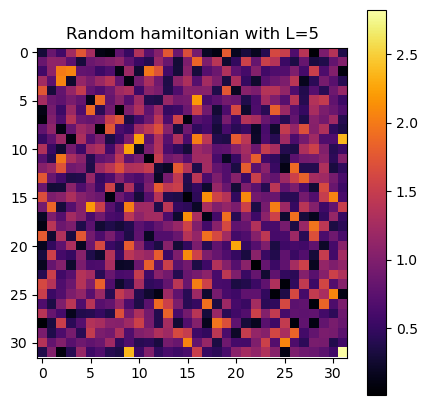

In [33]:
# backend
set_backend("qibojit", platform="numba")
# initialize dbi object
nqubits = 5
h0 = random_hermitian(2**nqubits, seed=2)
scheduling = DoubleBracketScheduling.hyperopt
mode = DoubleBracketGeneratorType.single_commutator
n_taylor = 5
dbi = DoubleBracketIteration(Hamiltonian(nqubits=nqubits, matrix=h0), scheduling=scheduling, mode=mode)
print("Initial off diagonal norm", dbi.off_diagonal_norm)
visualize_matrix(dbi.h.matrix, title=f'Random hamiltonian with L={nqubits}')

In [34]:
# generate the onsite Z operators
onsite_Z_ops = generate_onsite_Z_ops(nqubits)
d_coef = onsite_Z_decomposition(dbi.h.matrix, onsite_Z_ops)
d = sum([d_coef[i] * onsite_Z_ops[i] for i in range(nqubits)])
grad, s = gradient_onsite_Z(dbi, d=d, onsite_Z_ops=onsite_Z_ops)
print('The initial D coefficients:', d_coef)
print('Gradient:', grad)
print('s:', s)

[Qibo 0.2.7|WARNING|2024-03-26 16:07:47]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-03-26 16:07:47]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-03-26 16:07:47]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-03-26 16:07:47]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-03-26 16:07:47]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


100%|██████████| 500/500 [00:00<00:00, 691.96trial/s, best loss: 27.607175404720753]
The initial D coefficients: [(-0.2980910136757636+0j), (-0.17678355790937256+0j), (0.294550421681131+0j), (-0.2301056409534723+0j), (-0.07297191764284382+0j)]
Gradient: [-0.20478337  0.418433   -0.03167988  0.18669773 -0.86435984]
s: 0.11660954506915275


In [35]:
iters = 30
off_diagonal_norm = [dbi.off_diagonal_norm]
s_step = [0]
for i in range(iters):
    s, d_coef, d = gradient_descent_onsite_Z(dbi, d_coef=d_coef, d=d, onsite_Z_ops=onsite_Z_ops, max_evals=100)
    dbi(step=s, d=d)
    off_diagonal_norm.append(dbi.off_diagonal_norm)
    s_step.append(s)

100%|██████████| 500/500 [00:00<00:00, 669.37trial/s, best loss: 9.844996826247685] 


Text(0, 0.5, '$|| \\sigma(e^{sW}He^{-sW}) || $')

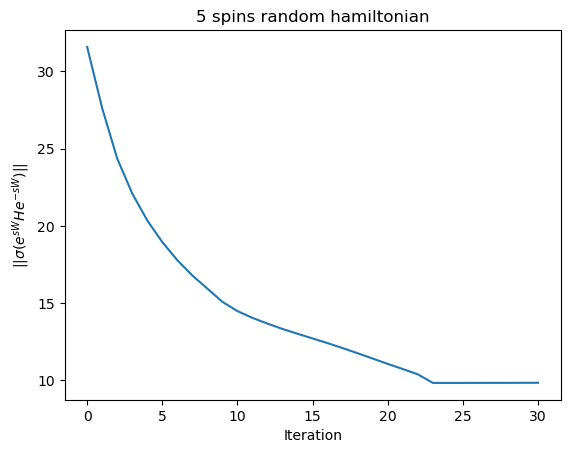

In [36]:
plt.title(str(nqubits) + ' spins random hamiltonian')
plt.plot(off_diagonal_norm)
plt.xlabel('Iteration')
plt.ylabel(r'$|| \sigma(e^{sW}He^{-sW}) || $')

## Test on TFIM
Here we choose to customize our TFIM in the X axis using `SymbolicHamiltonian`. It is also possible to use Hadamard gate to rotate the TFIM inbuilt in `qibo`.

$$ H = -(\sum X_i X_{i+1} + \sum hZ_i)

[Qibo 0.2.7|WARNING|2024-03-26 16:08:13]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


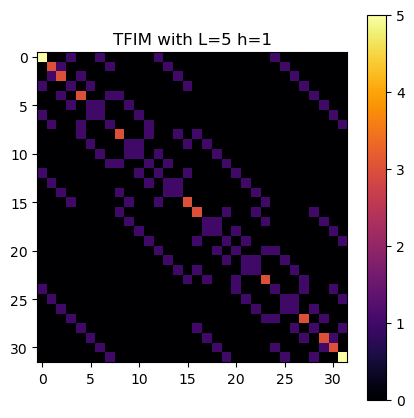

In [37]:
# generate the Hamiltonian
nqubits = 5
h = 1
H_TFIM = SymbolicHamiltonian( - h*symbols.Z(nqubits-1), nqubits=nqubits)
# add linear interaction terms
for i in range(nqubits-1):
    H_TFIM -= SymbolicHamiltonian(symbols.X(i)*symbols.X(i+1) + h*symbols.Z(i), nqubits=nqubits)
H_TFIM = H_TFIM.dense
visualize_matrix(H_TFIM.matrix, title=f'TFIM with L={nqubits} h={h}')

In [38]:
# backend
set_backend("qibojit", platform="numba")
# initialize dbi object
dbi_TFIM = DoubleBracketIteration(deepcopy(H_TFIM), scheduling=scheduling, mode=mode)

[Qibo 0.2.7|INFO|2024-03-26 16:08:14]: Using qibojit (numba) backend on /CPU:0


In [39]:
# generate the onsite Z operators
onsite_Z_ops = generate_onsite_Z_ops(nqubits)
d_coef = onsite_Z_decomposition(dbi_TFIM.h.matrix, onsite_Z_ops)
d = sum([d_coef[i] * onsite_Z_ops[i] for i in range(nqubits)])
grad, s = gradient_onsite_Z(dbi_TFIM, d, n=5, onsite_Z_ops=onsite_Z_ops)
print('Initial off-diagonal norm:', dbi.off_diagonal_norm)
print('The initial D coefficients:', d_coef)
print('Gradient:', grad)
print('s:', s)

[Qibo 0.2.7|WARNING|2024-03-26 16:08:14]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-03-26 16:08:14]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-03-26 16:08:14]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-03-26 16:08:14]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-03-26 16:08:14]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


100%|██████████| 500/500 [00:01<00:00, 383.66trial/s, best loss: 8.1443761719701]  
Initial off-diagonal norm: 9.844996868109437
The initial D coefficients: [(-1+0j), (-1+0j), (-1+0j), (-1+0j), (-1+0j)]
Gradient: [-0.22567346 -0.52080864 -0.59637211 -0.52080864 -0.22567346]
s: 0.05271207518843116


In [40]:
NSTEPS = 15
off_diagonal_norm_delta = [dbi_TFIM.off_diagonal_norm]
s_step_delta = [0]
for _ in range(NSTEPS):
    s, d_coef, d = gradient_descent_onsite_Z(dbi_TFIM, d_coef, d, onsite_Z_ops=onsite_Z_ops, max_evals=100, n=5, use_ds=True)
    dbi_TFIM(step=s, d=d)
    off_diagonal_norm_delta.append(dbi_TFIM.off_diagonal_norm)
    s_step_delta.append(s)
    print(f"New optimized step at iteration {_+1}/{NSTEPS}: {s} with d_coef {d_coef}, loss {dbi_TFIM.off_diagonal_norm}")

100%|██████████| 500/500 [00:00<00:00, 591.53trial/s, best loss: 8.145383187499851]
New optimized step at iteration 1/15: 0.05372645731587117 with d_coef [(-0.9894224152921011+0j), (-0.9787695132043422+0j), (-0.9750406784474285+0j), (-0.9787695132043422+0j), (-0.9894224152921011+0j)], loss 8.143621474679835
100%|██████████| 500/500 [00:00<00:00, 645.70trial/s, best loss: 7.605789256028495]
New optimized step at iteration 2/15: 0.05650469375482817 with d_coef [(-0.967659680502992+0j), (-1.1697984701193866+0j), (-1.1812229848159992+0j), (-1.169798470119386+0j), (-0.9676596805029926+0j)], loss 7.597613753384701
100%|██████████| 500/500 [00:00<00:00, 655.89trial/s, best loss: 7.428351470243482] 
New optimized step at iteration 3/15: 0.0398775478554277 with d_coef [(-0.9211510601202757+0j), (-1.8583923563596692+0j), (-1.3920649030243233+0j), (-1.8583923563596683+0j), (-0.9211510601202774+0j)], loss 7.340829616091421
100%|██████████| 500/500 [00:00<00:00, 662.71trial/s, best loss: 7.04449738

Text(0, 0.5, '$|| \\sigma(e^{sW}He^{-sW}) || $')

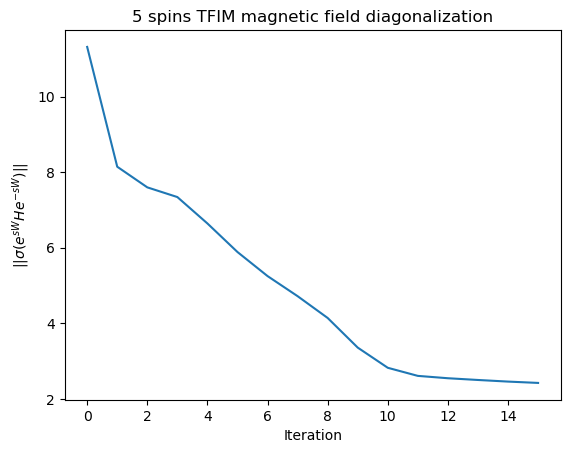

In [41]:
plt.title(str(nqubits) + ' spins TFIM magnetic field diagonalization')
plt.plot(off_diagonal_norm_delta)
plt.xlabel('Iteration')
plt.ylabel(r'$|| \sigma(e^{sW}He^{-sW}) || $')

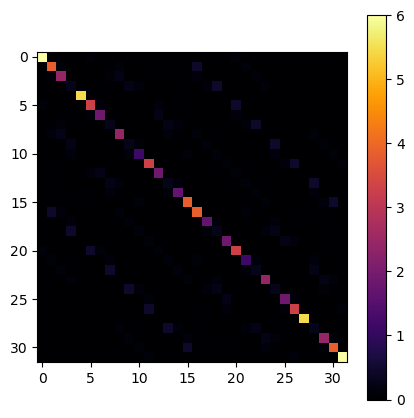

In [42]:
# the final matrix
visualize_matrix(dbi_TFIM.h.matrix)

## Different initial `d`
Next, we show the effect of different choices of the initial direction of the gradient descent method.

In [43]:
H = H_TFIM.matrix
L = int(np.log2(H.shape[0]))
N = np.diag(np.linspace(np.min(np.diag(H)),np.max(np.diag(H)),2**L))
d_coef = onsite_Z_decomposition(N, onsite_Z_ops)
print(d_coef)
d = sum([d_coef[i] * onsite_Z_ops[i] for i in range(nqubits)])

[(-2.580645161290323+0j), (-1.2903225806451613+0j), (-0.6451612903225807+0j), (-0.32258064516129037+0j), (-0.16129032258064518+0j)]


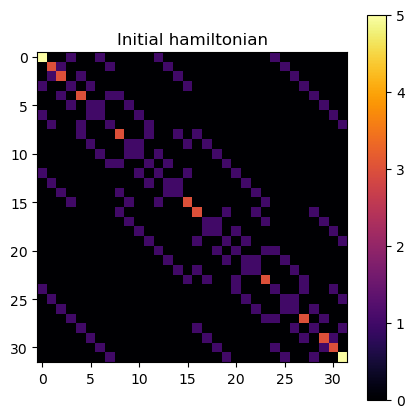

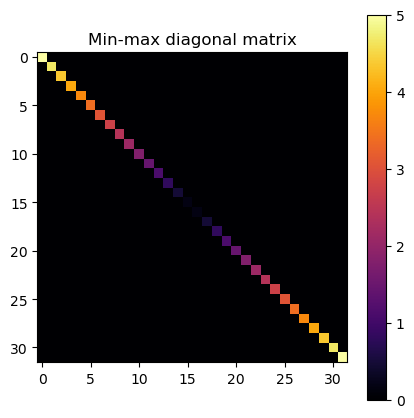

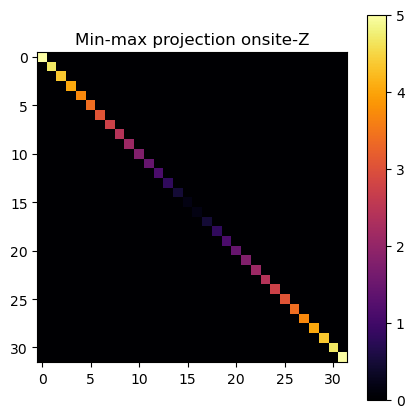

In [44]:
visualize_matrix(H, 'Initial hamiltonian')
visualize_matrix(N, 'Min-max diagonal matrix')
visualize_matrix(d, 'Min-max projection onsite-Z')

Here we see that the min-max diagonal operator can be correctly decomposed into onsite-Z operators. Then we generate the diagonalization curve and compare with other initializations.

In [45]:
# backend
set_backend("qibojit", platform="numba")
# initialize dbi object
dbi_TFIM_MMH = DoubleBracketIteration(deepcopy(H_TFIM), scheduling=scheduling, mode=mode)

[Qibo 0.2.7|INFO|2024-03-26 16:08:28]: Using qibojit (numba) backend on /CPU:0


In [46]:
NSTEPS = 15
off_diagonal_norm_MMH = [dbi_TFIM_MMH.off_diagonal_norm]
s_step_MMH = [0]
# d = np.diag(np.linspace(np.min(np.diag(dbi_TFIM_MMH.h.matrix)),np.max(np.diag(dbi_TFIM_MMH.h.matrix)),2**nqubits))
# d_coef = onsite_Z_decomposition(d, onsite_Z_ops)
for _ in range(NSTEPS):
    d = np.diag(np.linspace(np.min(np.diag(dbi_TFIM_MMH.h.matrix)),np.max(np.diag(dbi_TFIM_MMH.h.matrix)),2**nqubits))
    d_coef = onsite_Z_decomposition(d, onsite_Z_ops)
    s, d_coef, d = gradient_descent_onsite_Z(dbi_TFIM_MMH, d_coef, d, onsite_Z_ops=onsite_Z_ops, max_evals=100)
    dbi_TFIM_MMH(d=d, step=s)
    off_diagonal_norm_MMH.append(dbi_TFIM_MMH.off_diagonal_norm)
    s_step_MMH.append(s)
    print(f"New optimized step at iteration {_+1}/{NSTEPS}: {s} with d_coef {d_coef}, loss {dbi_TFIM_MMH.off_diagonal_norm}")

100%|██████████| 500/500 [00:00<00:00, 688.27trial/s, best loss: 9.336239342915379]
New optimized step at iteration 1/15: 0.039240166337035656 with d_coef [(-2.3180340693309422+0j), (-0.9042157574954297+0j), (-0.6267094129284807+0j), (-0.37510402952816974+0j), (-0.16137910360026844+0j)], loss 9.263805656974093
100%|██████████| 500/500 [00:00<00:00, 654.86trial/s, best loss: 8.253271106315344] 
New optimized step at iteration 2/15: 0.0636971166898561 with d_coef [(-2.8893154826347565+0j), (-1.3328071932958503+0j), (-0.5996311871447069+0j), (-0.38812640871658144+0j), (-0.16592899239661785+0j)], loss 8.248988639626276
100%|██████████| 500/500 [00:00<00:00, 705.90trial/s, best loss: 7.820911729728226] 
New optimized step at iteration 3/15: 0.026774099108320803 with d_coef [(-3.9047191557345737+0j), (-1.3620955366051533+0j), (-1.094932722170599+0j), (-0.5744178736473565+0j), (-0.04727696085745736+0j)], loss 7.79237041903216
100%|██████████| 500/500 [00:00<00:00, 522.76trial/s, best loss: 7.

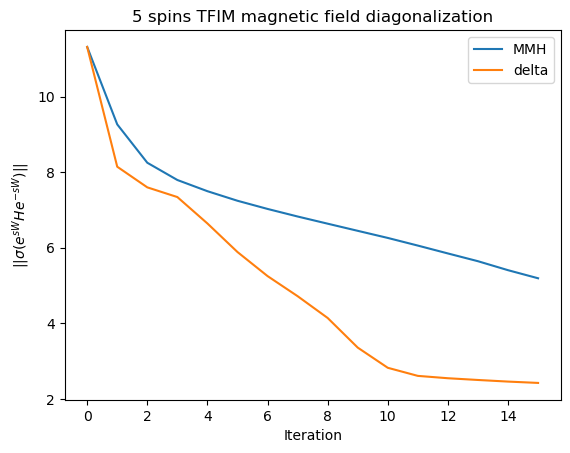

In [47]:
plt.title(str(nqubits) + ' spins TFIM magnetic field diagonalization')
plt.plot(off_diagonal_norm_MMH, label='MMH')
plt.plot(off_diagonal_norm_delta, label='delta')
plt.xlabel('Iteration')
plt.ylabel(r'$|| \sigma(e^{sW}He^{-sW}) || $')
plt.legend()

## Effect of `n`

[Qibo 0.2.7|INFO|2024-03-26 16:08:41]: Using qibojit (numba) backend on /CPU:0


Initial off diagonal norm 31.576176740060667


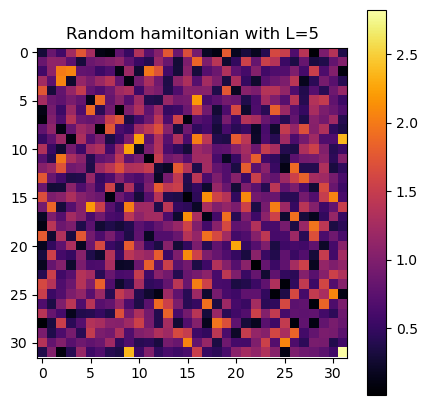

In [48]:
# backend
set_backend("qibojit", platform="numba")
# initialize dbi object
nqubits = 5
h0 = random_hermitian(2**nqubits, seed=2)
scheduling = DoubleBracketScheduling.hyperopt
mode = DoubleBracketGeneratorType.single_commutator
n_1 = 5
n_2 = 3
dbi_1 = DoubleBracketIteration(Hamiltonian(nqubits=nqubits, matrix=h0), scheduling=scheduling, mode=mode)
dbi_2 = DoubleBracketIteration(Hamiltonian(nqubits=nqubits, matrix=h0), scheduling=scheduling, mode=mode)
print("Initial off diagonal norm", dbi_1.off_diagonal_norm)
visualize_matrix(dbi_1.h.matrix, title=f'Random hamiltonian with L={nqubits}')

In [49]:
# generate the onsite Z operators
onsite_Z_ops = generate_onsite_Z_ops(nqubits)
d_coef = onsite_Z_decomposition(dbi.h.matrix, onsite_Z_ops)
d = sum([d_coef[i] * onsite_Z_ops[i] for i in range(nqubits)])
grad, s = gradient_onsite_Z(dbi,d,n=5, onsite_Z_ops=onsite_Z_ops)
print('The initial D coefficients:', d_coef)
print('Gradient:', grad)
print('s:', s)

[Qibo 0.2.7|WARNING|2024-03-26 16:08:41]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-03-26 16:08:41]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-03-26 16:08:41]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-03-26 16:08:41]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-03-26 16:08:41]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


100%|██████████| 500/500 [00:00<00:00, 697.70trial/s, best loss: 9.558186537868679] 
The initial D coefficients: [(-3.321354431855655-1.7961649980378765e-16j), (-0.7143725995296772+3.608986798092513e-17j), (0.472710854506152+9.347215093087467e-17j), (-0.5707798509274735-1.3813111045761499e-17j), (0.34536980200226214-1.1499770144849896e-16j)]
Gradient: [ 0.65534217  0.16603388 -0.31270245  0.27247095  0.60904527]
s: 0.024282460160549718


In [50]:
iters = 30
d_coef_1, d_1 = d_coef, d
d_coef_2, d_2 = d_coef, d

off_diagonal_norm_1 = [dbi_1.off_diagonal_norm]
off_diagonal_norm_2 = [dbi_2.off_diagonal_norm]
s_step_1 = [0]
s_step_2 = [0]
for i in range(iters):
    s_1, d_coef_1, d_1 = gradient_descent_onsite_Z(dbi_1, d_coef_1, d_1, onsite_Z_ops=onsite_Z_ops, n=n_1, max_evals=100)
    s_2, d_coef_2, d_2 = gradient_descent_onsite_Z(dbi_2, d_coef_2, d_2, onsite_Z_ops=onsite_Z_ops, n=n_2, max_evals=100)
    dbi_1(step=s_1, d=d_1)
    dbi_2(step=s_2, d=d_2)
    off_diagonal_norm_1.append(dbi_1.off_diagonal_norm)
    off_diagonal_norm_2.append(dbi_2.off_diagonal_norm)
    s_step_1.append(s_1)
    s_step_2.append(s_2)

100%|██████████| 500/500 [00:00<00:00, 723.56trial/s, best loss: 7.305839659415738] 


Text(0, 0.5, '$|| \\sigma(e^{sW}He^{-sW}) || $')

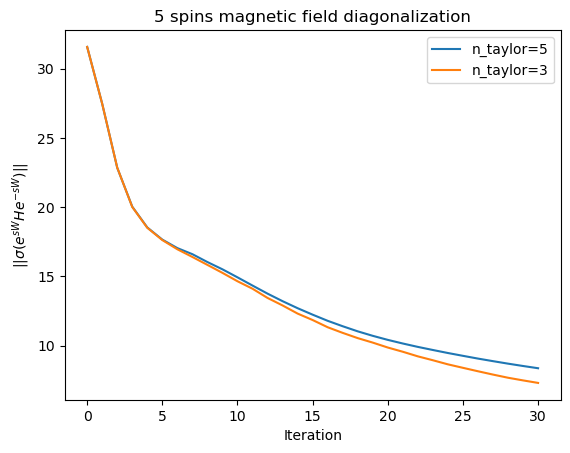

In [51]:
plt.title(str(nqubits) + ' spins magnetic field diagonalization')
plt.plot(off_diagonal_norm_1, label=f'n_taylor={n_1}')
plt.plot(off_diagonal_norm_2, label=f'n_taylor={n_2}')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel(r'$|| \sigma(e^{sW}He^{-sW}) || $')